**Machine Learning Basic Principles 2018 - Data Analysis Project Report. Group 256, Mathias Smeds and Mathias Fontell**

# *Title* 

*Title should be concise and informative, describes the approach to solve the problem. Some good titles from previous years:*

*- Comparing extreme learning machines and naive bayes’ classifier in spam detection*

*- Using linear discriminant analysis in spam detection*

*Some not-so-good titles:*

*- Bayesian spam filtering with extras*

*- Two-component classifier for spam detection*

*- CS-E3210 Term Project, final report*




## Abstract

*Precise summary of the whole report, previews the contents and results. Must be a single paragraph between 100 and 200 words.*



## 1. Introduction (SMEDS)

*Background, problem statement, motivation, many references, description of
contents. Introduces the reader to the topic and the broad context within which your
research/project fits*

*- What do you hope to learn from the project?*
*- What question is being addressed?*
*- Why is this task important? (motivation)*

*Keep it short (half to 1 page).*

.-.-.-.-.-.-.-.-

Assigning a genre to a song is a task at which even humans might have different opinions as to what is the correct genre. Thus we can expect that teaching a computer to correctly predict a genre for a given song is no easy feat.

Our task is to teach a computer to assign a genre to a song, based on data features extracted from the song. The two most important outcomes from this project are

1. How well can a computer predict the genre of a song based on simple Machine Learning algorithms
2. What preprocessing of the data is needed

We have two datasets consisting of song features, with one of the datasets being labeled to specific genres. Depending on the bitrate and audio format a single song can be several tens of megabytes, with normal listening bitrate for an mp3-file requiring at least a few megabytes. This means that using all bits in the song would result in a huge dataset impractical for our purposes. Because of this we have a dataset consisting of features engineered from the song, so that one song does not take up too much storage and computational resources.

The project consists of preprocessing the data and finding a training a predictor which performs well both in assigning each song a genre as well as having good confidence in that assignment.

Googling "machine learning song genre" gives almost 8 million hits. It seems to be an interesting problem for developing ML algorithms, maybe because of it being hard to perform better than humans. Perhaps the most popular machine learning solution for music is tha Shazam-app which can come up with a song title based on a sample from a song. Even though Shazam is not centered around finding good accurate genre labels for songs, it is still close enough to this project to show that applying Machine Learning to music is relevant both for business and science purposes.



## 2. Data analysis (FONTELL)

Before diving headfirst into classification and any derived machine earning (pun intended), we are well advised to familiarize ourselves with the data at hand. There are several reasons for doing this. First of all, identifying significant features or redundancy helps in finding a machine learning method most suitable for the data; the difference between trends that appear linear, polynomial, clustered or something completely alien can single out certain methods from the getgo. Moreover, filtering out redundant features improves the speed and often the accuracy of the selected classifier. As such, this section is tasked with addressing the following questions:

    - How are the classes distributed in the data? Is there a major representation of some classes?
    - What are the feature ranges, and is some pattern evident in the data?
    - Can the dimensionality of the data be reduced for improved speed and accuracy?

The songs in the dataset have been preprocessed into vectors of 264 features. The features contain information about the rhytm pattern, chroma and Mel Frequency Cepstral Coefficients (MFCC). Although a prior understanding of the technical details would certainly be useful, the conversion of an audio file into the MFCCs and rhythm/chroma patters is rather technical and well beyond the scope of this project. An overview of the procedure is presented in [1]; here we will not dwelve further into the details of the features. First, we start with investigating the class distribution.

Run the cell below to import the data an plot a histogram of the class distribution.

C:\Users\Mathias\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


(4363, 264) (6544, 264) (4363, 1)


C:\Users\Mathias\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
C:\Users\Mathias\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Text(0.5,1,'Histogram of class distribution')

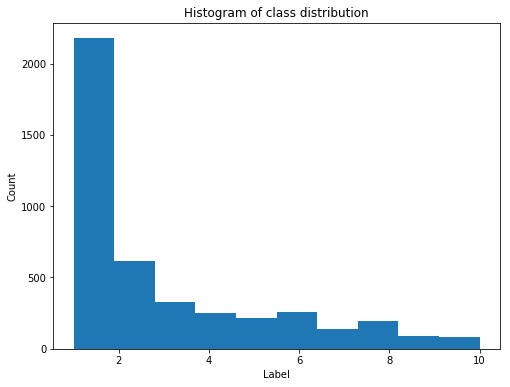

In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import random
from random import randint
from sklearn.model_selection import train_test_split

# Load the data and cleanup
train_data = pd.read_csv("train_data.csv", header=None).as_matrix()
test_data = pd.read_csv("test_data.csv", header=None).as_matrix()
train_labels = pd.read_csv("train_labels.csv", header=None).as_matrix()

print(train_data.shape, test_data.shape, train_labels.shape)
#Histogram of class distribution
fig=plt.figure(figsize=(8,6))
plt.hist(train_labels[:,0])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Figure 1: Histogram of class distribution')
#plt.show()

The histogram figure 1 shows that of the circa 4300 songs in the training dataset, almost 2000 represent label 1 i.e. pop. This appears to be a textbook example of an imbalanced dataset for classification; of the training labels, a disproportionate amount represent some label while some labels are wildly underrepresented. In the cells below, we present a function for undersampling a known genre by random selection to combat the imbalance. However, we will found out that this form of undersampling is not helpful - in fact, pop songs are so ubiquitous in any dataset we are likely to encounter, that we'd be well off trying to train our machine to at least classify pop songs correctly.

Then to the actual features. While the technical details of the features are rather complicated, it is prudent to at least investigate the feature range. In the cell below, we present scatter plots of a few selected column to better illuminate the data at hand. Run it to see what unfolds!

Text(0,0.5,'Label')

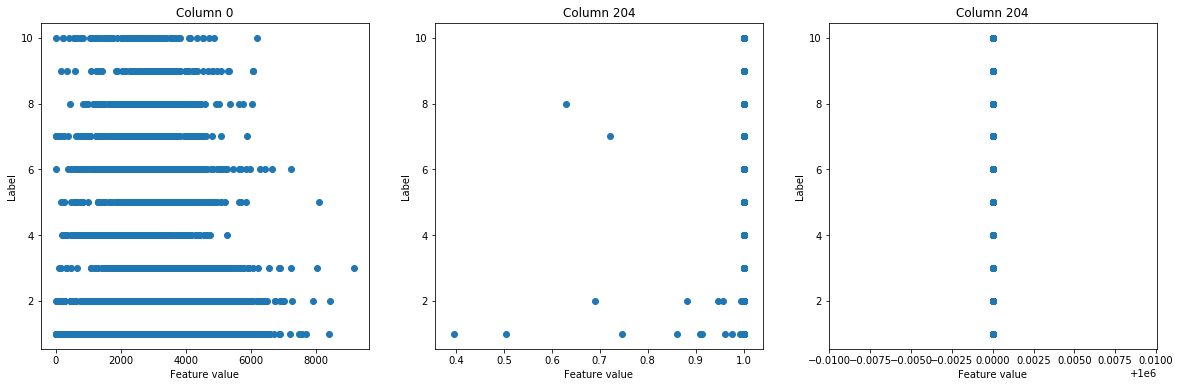

In [16]:
fig=plt.figure(figsize=(8,6))
fig.set_figwidth(20)

plt.subplot(1,3,1)
plt.scatter(train_data[:,0],train_labels.ravel())
plt.title('Column 0')
plt.xlabel('Feature value')
plt.ylabel('Label')

plt.subplot(1,3,2)
plt.scatter(train_data[:,204],train_labels.ravel())
plt.title('Column 204')
plt.xlabel('Feature value')
plt.ylabel('Label')

plt.subplot(1,3,3)
plt.scatter(train_data[:,216],train_labels.ravel())
plt.title('Column 204')
plt.xlabel('Feature value')
plt.ylabel('Label')

Upon closer inspection of the data we see that many columns seem to have bad data. 
For example column with index 204 has mostly ones and column with index 216 is almost all 1E+06.
In the cell below we remove the coumns having bad data.

Text(0.5,1,'Validation data after split')

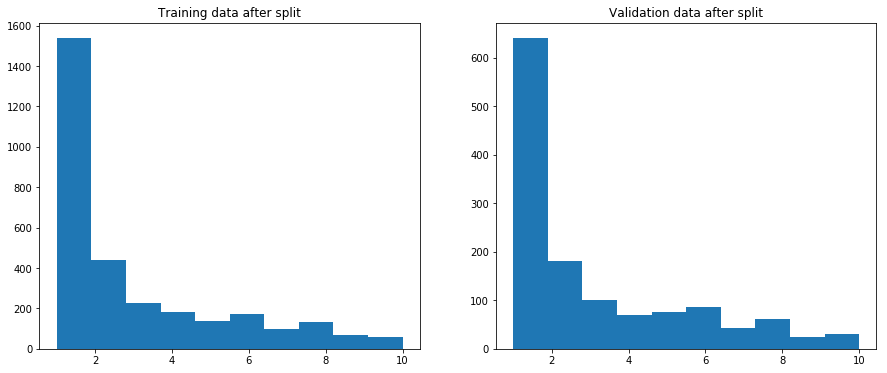

In [4]:
#Divide data into training data (70%) and validation data (30%)
#normalize the data: support vector machines work better this way
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data=scaler.fit_transform(train_data)

tdata, vdata, tlabels, vlabels = train_test_split(data, train_labels.ravel(), test_size=0.3, random_state=66)

def undersample_genre(features, labels, remaining, genre):
#Input: N x D features matrix, N x 1 labels matrix, remaining percentage of rows corresponding to label genre
#Output: (remaining*N) x D features matrix, (remaining*N) x 1 labels matrix
#remove some of those damn pop songs randomly
    N_data=features.shape[0]
    N_genre=0
    for i in range(N_data):
        if(labels[i]==genre):
            N_genre+=1
            
    to_delete=int(np.floor((1.0-remaining)*N_genre))
    deleted=0
    while(deleted<to_delete):
        #pick random row in tdata
        rand_row=randint(0, features.shape[0]-1)
        if(labels[rand_row]==genre):
            rand=random.uniform(0, 1)
            if(rand>remaining):
                #remove this row from tdata
                features = np.delete(features, (rand_row), axis=0)
                labels = np.delete(labels, (rand_row), axis=0)
                deleted+=1
    return features, labels

#tdata,tlabels=undersample_genre(tdata,tlabels,0.3,1)
#vdata,vlabels=undersample_genre(vdata,vlabels,0.3,1)

fig=plt.figure(figsize=(8,6))
fig.set_figwidth(15)

plt.subplot(1,2,1)
plt.hist(tlabels)
plt.title('Training data after split')

plt.subplot(1,2,2)
plt.hist(vlabels)
plt.title('Validation data after split')



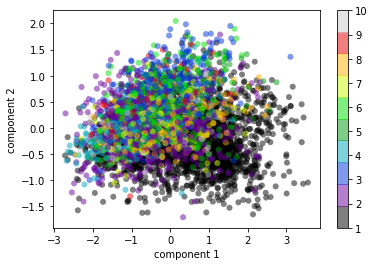

In [11]:
#Analysis of the input data: MATTI
#TODO: Counteract imbalance in data set

N=data.shape[0]
C = np.cov(np.transpose(data)) #data=normalize training data
values, vectors = np.linalg.eig(C)
idx = (values.real).argsort()[::-1]   
values_sorted = (values[idx]).real
vectors_sorted = vectors[:,idx]

#test principal component analysis of data
pca=PCA(n_components = 200)
pca.fit(data)

#TODO: NORMALIZE THE DATA FIRST!
#traindata_PCA=pca.transform(train_data) n
#testdata_PCA=pca.transform(test_data)

data_PCA=pca.transform(data)
tdata_PCA=pca.transform(tdata) #tdata and vdata have been normalize to between 0 and 1 in the previous cell
vdata_PCA=pca.transform(vdata)

plt.scatter(data_PCA[:, 0], data_PCA[:, 1],
            c=train_labels.ravel(), edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
 

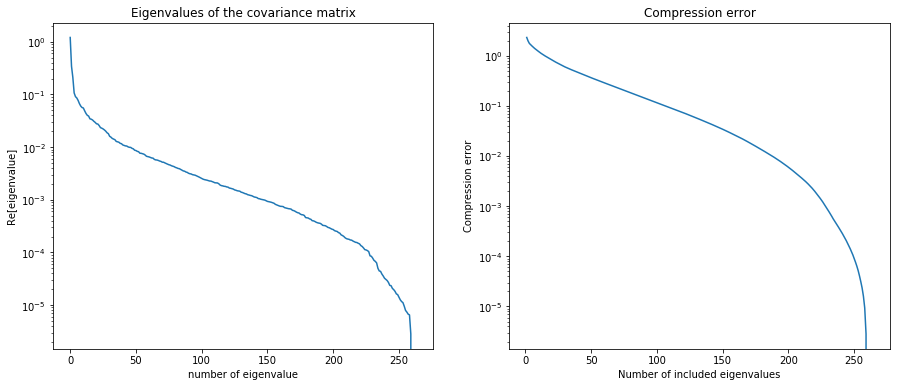

In [6]:
D=values_sorted.shape[0]
compression_error=np.zeros((1,D))
number_included=np.zeros((1,D))
for i in range(D):
    sum=0
    for j in range(i+1,D):
        sum+=values_sorted[j]
    compression_error[0,i]=sum
    number_included[0,i]=i+1
  
fig=plt.figure(figsize=(8,6))
fig.set_figwidth(15)
plt.subplot(1,2,1)
plt.plot(values_sorted[:])
plt.xlabel('number of eigenvalue')
plt.semilogy()
plt.ylabel('Re[eigenvalue]')
plt.title("Eigenvalues of the covariance matrix")

plt.subplot(1,2,2)
plt.plot(number_included[0,:],compression_error[0,:])
plt.xlabel('Number of included eigenvalues')
plt.semilogy()
plt.ylabel('Compression error')
plt.title("Compression error")
plt.show()

## 3. Methods and experiments (MATTE)

*- Explain your whole approach (you can include a block diagram showing the steps in your process).* 

*- What methods/algorithms, why were the methods chosen. *

*- What evaluation methodology (cross CV, etc.).*



In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

#Matter, obs: traindata_PCA eller train_data är inte normaliserad, och funkar dåligt. 'data' är normaliserad train_data till [0,1]
#Använd alltså 'data' iställe, se cell 2
param_grid = {
                 'n_estimators': [20, 40, 60, 80, 100],
                 'max_depth': [2, 5, 7, 9, 11, 13, 15]
             }


X_train, X_test, y_train, y_test = train_test_split(traindata_PCA, train_labels.ravel(), test_size=0.33, random_state=66)

# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

cross_val_score(rfc, traindata_PCA, train_labels.ravel(), cv=10)

from sklearn.grid_search import GridSearchCV

grid_clf = GridSearchCV(rfc, param_grid, cv=10)
grid_clf.fit(traindata_PCA, train_labels.ravel())
grid_clf.grid_scores_

C:\Users\Mathias\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Mathias\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


[mean: 0.50172, std: 0.00487, params: {'max_depth': 2, 'n_estimators': 20},
 mean: 0.50034, std: 0.00245, params: {'max_depth': 2, 'n_estimators': 40},
 mean: 0.50057, std: 0.00340, params: {'max_depth': 2, 'n_estimators': 60},
 mean: 0.49966, std: 0.00284, params: {'max_depth': 2, 'n_estimators': 80},
 mean: 0.50034, std: 0.00437, params: {'max_depth': 2, 'n_estimators': 100},
 mean: 0.54206, std: 0.01111, params: {'max_depth': 5, 'n_estimators': 20},
 mean: 0.54641, std: 0.00837, params: {'max_depth': 5, 'n_estimators': 40},
 mean: 0.54756, std: 0.01001, params: {'max_depth': 5, 'n_estimators': 60},
 mean: 0.54825, std: 0.01137, params: {'max_depth': 5, 'n_estimators': 80},
 mean: 0.55031, std: 0.00760, params: {'max_depth': 5, 'n_estimators': 100},
 mean: 0.55191, std: 0.00986, params: {'max_depth': 7, 'n_estimators': 20},
 mean: 0.55604, std: 0.01299, params: {'max_depth': 7, 'n_estimators': 40},
 mean: 0.55879, std: 0.01270, params: {'max_depth': 7, 'n_estimators': 60},
 mean: 0.5

In [ ]:
#Matti's cross validation test
#this doesnt work
from sklearn.metrics import accuracy_score
from sklearn import svm, grid_search, datasets
parameters = {'kernel':('linear', 'rbf','poly'), 'degree':[1, 2,3,4]}
svr = svm.SVC(max_iter=10000)
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(data, train_labels.ravel())
clf.best_score_

#from sklearn import svm
#print(tdata.shape)

'''
#My best performance: clf = svm.SVC(kernel='poly',degree=3,gamma=0.1,max_iter=100000)
w={1:3, 2:4, 3:5, 4:5, 5:5, 6:5, 7:5, 8:5, 9:5, 10:5}
gammas=np.linspace(0.1, 1.0, num=1)
for j in range(len(gammas)):
    g=gammas[j]
    clf = svm.SVC(kernel='poly',degree=3,gamma=g,max_iter=100000)
    clf.fit(tdata, tlabels.ravel())
    labels_pred=clf.predict(vdata)
    acc = accuracy_score(vlabels.ravel(), labels_pred.ravel())
    print(g,acc)
'''




C:\Users\Mathias\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Mathias\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [25]:
#Choosing how much of the PCA data to include.
#We see that there is a significant drop in the computation error and eigenvalues somewhere near the 175th eigenvalue

print(values_sorted[170:180])
#From this we see that a reasonable cutoff point is at the 175th eigenvalue

print(values_sorted[250:])

# Trials with ML algorithms



#TODO
#Polynomial regression

#Mattes algoritmer
#Try 1, LinearRegression
#classifier_1 = linear_model.LinearRegression().fit(traindata_PCA, train_labels)
#score1 = classifier_1.score(traindata_PCA, train_labels)
#classifier_1.predict(testdata_PCA)

#Try 2, SVM
#classifier_2 = SVC(gamma='auto')
#classifier_2.fit(train_data, train_labels.values.ravel())
#classifier_2.score(train_data, train_labels.values.ravel())

#Try 3, Deep learning
#classifier_3 = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(5, 2), random_state=1)
#classifier_3.fit(traindata_PCA, train_labels)
#score3 = classifier_3.score(traindata_PCA, train_labels)

#Try 4, Bayesian Ridge regression
#classifier_4 = linear_model.BayesianRidge().fit(traindata_PCA, train_labels)
#score4 = classifier_4.score(traindata_PCA, train_labels)

#Try 5, Random Forest
classifier_5 = RandomForestClassifier(n_estimators=100, max_depth = 10)
classifier_5.fit(traindata_PCA, train_labels.ravel())
score5 = classifier_5.score(traindata_PCA, train_labels.ravel())
classifier_5_output = classifier_5.predict(testdata_PCA)
classifier_5_output_logloss = classifier_5.predict_proba(testdata_PCA)


#Output
#print("Linear regression score: ", score1)
#print("Deep learning score: ", score3)
#print("Bayesian Ridge Regression score: ", score4)
print("Random Forest score: ", score5)


[0.76394858 0.46843531 0.12161903 0.06402273 0.04634457 0.03145128
 0.02801016 0.02025193 0.01936487 0.01664958]
[ 3.58857806e-05  3.46824472e-05  3.30976375e-05  3.19090511e-05
  3.01583150e-05  2.69840906e-05  2.29438184e-05  1.46351876e-05
  1.10981295e-05  6.23466415e-06  2.81908471e-06  1.32990008e-20
 -1.21484117e-20 -1.21484117e-20]
Random Forest score:  0.5273894109557644


In [ ]:
#Mattis algoritmer
#Try the same as above, but for the reduced data

classifier_5_reduced = RandomForestClassifier(n_estimators=10, max_depth = 10).fit(traindata_PCA, train_labels.values.ravel())
score5_reduced = classifier_5_reduced.score(traindata_PCA, train_labels.values.ravel())
classifier_5_reduced_output = classifier_5_reduced.predict(testdata_PCA)


#Output
print("Random Forest score with PCA compression, boom: ", score5_reduced)



## 4. Results (Output: Smeds, Confusion matrix: Fontell)

*Summarize the results of the experiments without discussing their implications.*

*- Include both performance measures (accuracy and LogLoss).*

*- How does it perform on kaggle compared to the train data.*

*- Include a confusion matrix.*



In [ ]:
#Confusion matrix ...

#Output for Accuracy competition
output_csv = pd.DataFrame({'Sample_label': classifier_5_output})
output_csv.index += 1
output_csv.index.names = ['Sample_id']

#Output for Logloss competition
output_csv2 = pd.DataFrame(classifier_5_output_logloss, columns=['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5','Class_6','Class_7','Class_8','Class_9','Class_10',])
output_csv2.index += 1
output_csv2.index.names = ['Sample_id']

#output_csv.rename({1: "Sample_id", 2: "Sample_label"}, index=)
output_csv.to_csv('upload_to_kaggle_accuracy.csv')
output_csv2.to_csv('upload_to_kaggle_logloss.csv')


## 5. Discussion/Conclusions

*Interpret and explain your results *

*- Discuss the relevance of the performance measures (accuracy and LogLoss) for
imbalanced multiclass datasets. *

*- How the results relate to the literature. *

*- Suggestions for future research/improvement. *

*- Did the study answer your questions? *



## 6. References

[1] N.M. Patil, M.U. Nemande: "Music Genre Classification Using MFCC, K-NN and SVM Classifier". International Journal of Computer Engineering In Research Trends, Vol. 4, Issue 2, pp 43-47, 2017.

## Appendix
*Any additional material needed to complete the report can be included here. For example, if you want to keep  additional source code, additional images or plots, mathematical derivations, etc. The content should be relevant to the report and should help explain or visualize something mentioned earlier. **You can remove the whole Appendix section if there is no need for it.** *